In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

In [2]:
# Useful functions
model = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1')

def extract_entity_from_question(question):
    """
    Extract the entity that is enclosed in square brackets from the question.
    Example: "What city is [Paris] the capital of?" -> "Paris"
    """
    # assumes one entity of interest in each questin
    start = question.find('[') + 1
    end = question.find(']')
    if start == 0 or end == -1:
        raise ValueError(f"No entity found in the question: {question}")
    return question[start:end]

def assign_entity_types(row):
    if row["relation"] == "directed_by":
        return "Movie", "Director"
    elif row["relation"] == "written_by":
        return "Movie", "Writer"
    elif row["relation"] == "starred_actors":
        return "Movie", "Actor"
    elif row["relation"] == "has_tags":
        return "Movie", "Tag"
    elif row["relation"] == "has_genre":
        return "Movie", "Genre"
    elif row["relation"] == "has_imdb_rating":
        return "Movie", "Rating"
    elif row["relation"] == "has_imdb_votes":
        return "Movie", "Votes"
    elif row["relation"] == "in_language":
        return "Movie", "Language"
    elif row["relation"] == "release_year":
        return "Movie", "Year"
    
def generate_nx_graph(path_to_kb, collaspe_relations=False):
    """
    Constructs a networkx directed graph that includes both the original and reverse relations. 
    If collaspe_relations=True, each edge includes the concatenated relations between the same pairs of entities.
    """
    df = pd.read_csv(path_to_kb, sep='|', header=None, names=['entity1', 'relation', 'entity2'])
    
    # Remove duplicates
    df_unique = df.drop_duplicates().copy() # 133582 edges after dedup

    # Append entity type
    df_unique.loc[:, 'subject_type'], df_unique.loc[:, 'object_type'] = zip(*df_unique.apply(assign_entity_types, axis=1))

    # Define reverse relations and construct reverse edges
    reverse_relations = {
    'directed_by': 'directed',
    'written_by': 'written',
    'starred_actors': 'starring',
    'has_tags': 'is_tagged_to',
    'has_genre': 'is_genre_of',
    'has_imdb_rating': 'is_imdb_rating_of',
    'has_imdb_votes': 'is_imdb_votes_of',
    'in_language': 'language_of',
    'release_year': 'is_released_year_of'
    }

    reverse_rows = []
    for index, row in df_unique.iterrows():
        reverse_relation = reverse_relations[row['relation']]
        reverse_row = {'entity1': row['entity2'], 'relation': reverse_relation, 'entity2': row['entity1'],
                    'subject_type': row['object_type'], 'object_type': row['subject_type']}
        reverse_rows.append(reverse_row)

    df_reverse = pd.DataFrame(reverse_rows) # 133582 edges
    df_combined = pd.concat([df_unique, df_reverse], ignore_index=True) # 267164 edges
    
    if collaspe_relations:
        # This step consolidates multiple edges between the same pair of entities into a single edge.
        # It concatenates all relation values associated with each pair of entities.
        df_final = df_combined.groupby(['entity1', 'entity2'], as_index=False).agg({
            'relation': ' and '.join 
        }) # 249349 edges

        # Replace underscores in relation names
        df_final['relation'] = df_final['relation'].str.replace('_', ' ')

        G = nx.from_pandas_edgelist(df_final, source='entity1', target='entity2', edge_attr='relation', create_using=nx.DiGraph())
        # Number of entities: 43234
        # Number of edges: 249349
        # Number of distinct relations: 38
        # Distinct relations: {'release year', 'directed by and written by and starred actors', 'directed by and starred actors', 'has imdb rating', 'is genre of', 'has tags and is tagged to', 'directed by and written by', 'starred actors and starring', 'directed', 'directed and written', 'has imdb votes', 'written by and directed by', 'written and directed', 'in language and language of', 'language of', 'has genre', 'is tagged to', 'has imdb rating and has tags', 'directed and written and starring', 'starred actors', 'starring', 'has tags', 'directed and starring', 'written by and directed by and starred actors', 'written by and written', 'written by', 'in language', 'release year and has tags', 'written and directed and starring', 'written and starring', 'is released year of and is tagged to', 'directed by', 'is imdb rating of', 'is imdb rating of and is tagged to', 'written', 'is released year of', 'written by and starred actors', 'is imdb votes of'}
        return G, df_final
    else: 
        G = nx.from_pandas_edgelist(df_combined, source='entity1', target='entity2', edge_attr='relation', create_using=nx.MultiDiGraph())
        # Number of entities: 43234
        # Number of edges: 267164
        # Number of distinct relations: 18
        # Distinct relations:  {'has_imdb_votes', 'has_tags', 'starring', 'has_genre', 'is_imdb_rating_of', 'directed_by', 'is_genre_of', 'has_imdb_rating', 'in_language', 'written', 'language_of', 'starred_actors', 'written_by', 'release_year', 'is_imdb_votes_of', 'is_released_year_of', 'directed', 'is_tagged_to'}
        return G, df_combined
    
def load_node2vec_embeddings(file_path, embedding_dim=64):
    embeddings_dict = {}
    
    with open(file_path, 'r') as f:
        # Skip the first row
        next(f)

        for line in f:
            parts = line.strip().split()
            
            # The entity is everything before the embedding, so we use -embedding_dim
            entity = " ".join(parts[:-embedding_dim])  # Join all words before the embedding dimensions
            embedding = list(map(float, parts[-embedding_dim:]))  # Convert last parts to float
            
            # Store in the dictionary
            embeddings_dict[entity] = embedding
    
    return embeddings_dict

def find_paths(G, u, n):
    """
    Finds paths in a graph G starting from node u with until reaching a maximum length of n edges.

    Parameters:
    G (Graph): The nx graph where entities and relations are defined.
    u (str): The starting node for the paths. 
    n (int): The maximum depth or length of paths in terms of edges.
    
    Returns:
    List of paths, where each path is a list of tuples (node, relation) representing 
    the nodes and relations along the path.
    """
        
    if n == 0:
        return [[(u, None)]] 

    paths = [
        [(u, G[u][neighbor]['relation'])] + path
        for neighbor in G.neighbors(u)
        for path in find_paths(G, neighbor, n - 1)
        if u not in [node for node, _ in path] # Avoid cycles
    ]
    return paths

def find_best_embedding(G, query_entity, q_embedding):
    """
    Finds the best path embedding for each unique candidate based on cosine similarity.
    
    Parameters:
    G (Graph): The nx graph where entities and relations are defined.
    query_entity (str): The entity for which paths are being found.
    q_embedding (torch.Tensor): The embedding of the query entity.

    Returns:
    dict: A dictionary where keys are candidates and values are the best path embeddings.
    """

    paths = find_paths(G, query_entity, 2) + find_paths(G, query_entity, 1)

    sentences = []
    candidates = []

    for tuple_list in paths:
        # Extract the last entity (candidate) in the path
        candidate_entity = tuple_list[-1][0]
        
        if candidate_entity != query_entity: # Avoid looping back to the query_entity
            candidates.append(candidate_entity)
            # Create the sentence for the path
            sentence = ' '.join(f"{tup[0]} {tup[1]}" if tup[1] else tup[0] for tup in tuple_list)
            sentences.append(sentence)

    # Calculate path embeddings
    path_embeddings = model.encode(sentences, batch_size=128, convert_to_tensor=True)
    # Calculate cosine similarities
    cosine_scores = util.cos_sim(q_embedding, path_embeddings)[0]

    # Dictionary to store the best path embedding for each candidate
    best_embeddings = {}
    # Dictionary to store the highest cosine score for each candidate
    best_scores = {}

    for idx, candidate in enumerate(candidates):
        cosine_score = cosine_scores[idx].item()
        
        if candidate not in best_embeddings or cosine_score > best_scores[candidate]:
            best_scores[candidate] = cosine_score
            best_embeddings[candidate] = path_embeddings[idx]

    return best_embeddings

Read qa data and get query and answer entities for each query
-   qa data from vanilla 2-hop/qa_train.txt

In [ ]:
path_to_qa = '../Datasets/MetaQA_dataset/raw/vanilla 2-hop/qa_train.txt'
qa_df = pd.read_csv(path_to_qa, sep='\t', header=None, names=['question', 'answer'])

# Get query entity for each query
qa_df['query_entity'] = qa_df['question'].apply(extract_entity_from_question)
query_entities = qa_df['query_entity'].tolist()

# Get answer entities for each query
qa_df['answer'] = qa_df['answer'].apply(lambda x: x.split("|"))
answers = qa_df['answer'].to_list()

# Get question for each query
qa_df['question'] = qa_df['question'].str.replace(r'[\[\]]', '', regex=True)
questions = qa_df['question'].to_list()

Construct G and get corrsponding kb dataframe
-   Here, G is constructed without concatenated relations

In [ ]:
path_to_kb = '../Datasets/MetaQA_dataset/raw/kb.txt'
G, kb_df = generate_nx_graph(path_to_kb)

num_nodes = G.number_of_nodes()
print(f"Number of entities: {num_nodes}")

num_edges = G.number_of_edges()
print(f"Number of edges: {num_edges}")

distinct_relations = set(nx.get_edge_attributes(G, 'relation').values())
print(f"Number of distinct relations: {len(distinct_relations)}")
print("Distinct relations:", distinct_relations)

Number of entities: 43234
Number of edges: 267164
Number of distinct relations: 18
Distinct relations: {'written_by', 'starring', 'release_year', 'has_tags', 'language_of', 'has_imdb_votes', 'has_imdb_rating', 'directed_by', 'is_imdb_rating_of', 'is_released_year_of', 'is_tagged_to', 'directed', 'written', 'has_genre', 'is_genre_of', 'is_imdb_votes_of', 'starred_actors', 'in_language'}


In [5]:
kb_df

entity1        relation           entity2 subject_type  \
0                 Kismet     directed_by  William Dieterle        Movie   
1                 Kismet      written_by   Edward Knoblock        Movie   
2                 Kismet  starred_actors  Marlene Dietrich        Movie   
3                 Kismet  starred_actors     Edward Arnold        Movie   
4                 Kismet  starred_actors     Ronald Colman        Movie   
...                  ...             ...               ...          ...   
267159            comedy    is_tagged_to                Go          Tag   
267160      sarah polley    is_tagged_to                Go          Tag   
267161  timothy olyphant    is_tagged_to                Go          Tag   
267162      katie holmes    is_tagged_to                Go          Tag   
267163        doug liman    is_tagged_to                Go          Tag   

       object_type  
0         Director  
1           Writer  
2            Actor  
3            Actor  
4            Actor  
...            ...  
267159       Movie  
267160       Movie  
267161       Movie  
267162       Movie  
267163       Movie  

[267164 rows x 5 columns]

In [6]:
kb_df['relation'].value_counts()

relation
starred_actors         33718
starring               33718
is_tagged_to           28719
has_tags               28719
written_by             19127
written                19127
release_year           16715
is_released_year_of    16715
directed_by            15957
directed               15957
has_genre              15485
is_genre_of            15485
language_of             3428
in_language             3428
has_imdb_rating          314
is_imdb_rating_of        314
has_imdb_votes           119
is_imdb_votes_of         119
Name: count, dtype: int64

Add node attribute for nodes in G

In [7]:
entity_to_type = pd.concat([
    kb_df[['entity1', 'subject_type']].rename(columns={'entity1': 'entity', 'subject_type': 'entity_type'}),
    kb_df[['entity2', 'object_type']].rename(columns={'entity2': 'entity', 'object_type': 'entity_type'})
], ignore_index=True)

entity_to_type = entity_to_type.drop_duplicates()
entity_to_type

entity entity_type
0                          Kismet       Movie
9            Flags of Our Fathers       Movie
23           The Bride Wore Black       Movie
37              Dirty Filthy Love       Movie
45                 The Dark Horse       Movie
...                           ...         ...
267130  Olaf de Fleur Johannesson      Writer
267135             Philip Moeller    Director
267145                 Alki David    Director
267146                 Alki David      Writer
267149                 Alki David       Actor

[48636 rows x 2 columns]

In [8]:
entity_to_type['entity_type'].value_counts()

entity_type
Movie       16427
Writer      10541
Actor       10305
Director     6241
Tag          4892
Year          104
Language       97
Genre          23
Votes           3
Rating          3
Name: count, dtype: int64

In [9]:
entity_types_grouped = entity_to_type.groupby('entity')['entity_type'].unique()

for entity, entity_types in entity_types_grouped.items():
    # Assign the unique entity_types as the node attribute for each entity
    G.nodes[entity]['entity_type'] = list(entity_types)

for node, data in G.nodes(data=True):
    print(f"Node: {node}, Attributes: {data}")

Node: Kismet, Attributes: {'entity_type': ['Movie']}
Node: William Dieterle, Attributes: {'entity_type': ['Director']}
Node: Edward Knoblock, Attributes: {'entity_type': ['Writer']}
Node: Marlene Dietrich, Attributes: {'entity_type': ['Actor']}
Node: Edward Arnold, Attributes: {'entity_type': ['Actor']}
Node: Ronald Colman, Attributes: {'entity_type': ['Actor']}
Node: James Craig, Attributes: {'entity_type': ['Actor']}
Node: 1944, Attributes: {'entity_type': ['Year']}
Node: English, Attributes: {'entity_type': ['Language']}
Node: bd-r, Attributes: {'entity_type': ['Tag']}
Node: Flags of Our Fathers, Attributes: {'entity_type': ['Movie']}
Node: Clint Eastwood, Attributes: {'entity_type': ['Director', 'Actor']}
Node: Paul Haggis, Attributes: {'entity_type': ['Writer', 'Director']}
Node: Ron Powers, Attributes: {'entity_type': ['Writer']}
Node: James Bradley, Attributes: {'entity_type': ['Writer']}
Node: 2006, Attributes: {'entity_type': ['Year']}
Node: War, Attributes: {'entity_type': ['

Let's get the degree of nodes for G
-   node entity type of Genre generally has higher degree

In [10]:
sorted_by_degree = sorted(dict(G.degree()).items(), key=lambda item: item[1], reverse=True)

node_entity_types = {node: G.nodes[node].get('entity_type', 'Unknown') for node in G.nodes}

degree_by_entity_type = []
# Step 4: Print node, degree, and entity type
for node, degree in sorted_by_degree:
    entity_type = node_entity_types.get(node, 'Unknown')
    degree_by_entity_type.append((entity_type, degree))
    print(f"Node: {node}, Degree: {degree}, Entity Type: {entity_type}")

Node: Drama, Degree: 8352, Entity Type: ['Genre']
Node: Comedy, Degree: 7854, Entity Type: ['Genre']
Node: Horror, Degree: 2366, Entity Type: ['Genre']
Node: bd-r, Degree: 2002, Entity Type: ['Tag']
Node: Action, Degree: 1848, Entity Type: ['Genre']
Node: Thriller, Degree: 1804, Entity Type: ['Genre']
Node: French, Degree: 1552, Entity Type: ['Language']
Node: Crime, Degree: 1472, Entity Type: ['Genre']
Node: 2009, Degree: 1180, Entity Type: ['Year']
Node: 2007, Degree: 1090, Entity Type: ['Year']
Node: 2008, Degree: 1076, Entity Type: ['Year']
Node: 2012, Degree: 1036, Entity Type: ['Movie', 'Year']
Node: 2011, Degree: 1026, Entity Type: ['Year']
Node: comedy, Degree: 1008, Entity Type: ['Tag']
Node: 2010, Degree: 1004, Entity Type: ['Movie', 'Year']
Node: 2013, Degree: 996, Entity Type: ['Year']
Node: 2006, Degree: 978, Entity Type: ['Year']
Node: War, Degree: 940, Entity Type: ['Movie', 'Genre']
Node: English, Degree: 924, Entity Type: ['Language']
Node: r, Degree: 910, Entity Type:

Plot node degree distribution for each entity type (hiding outliers)

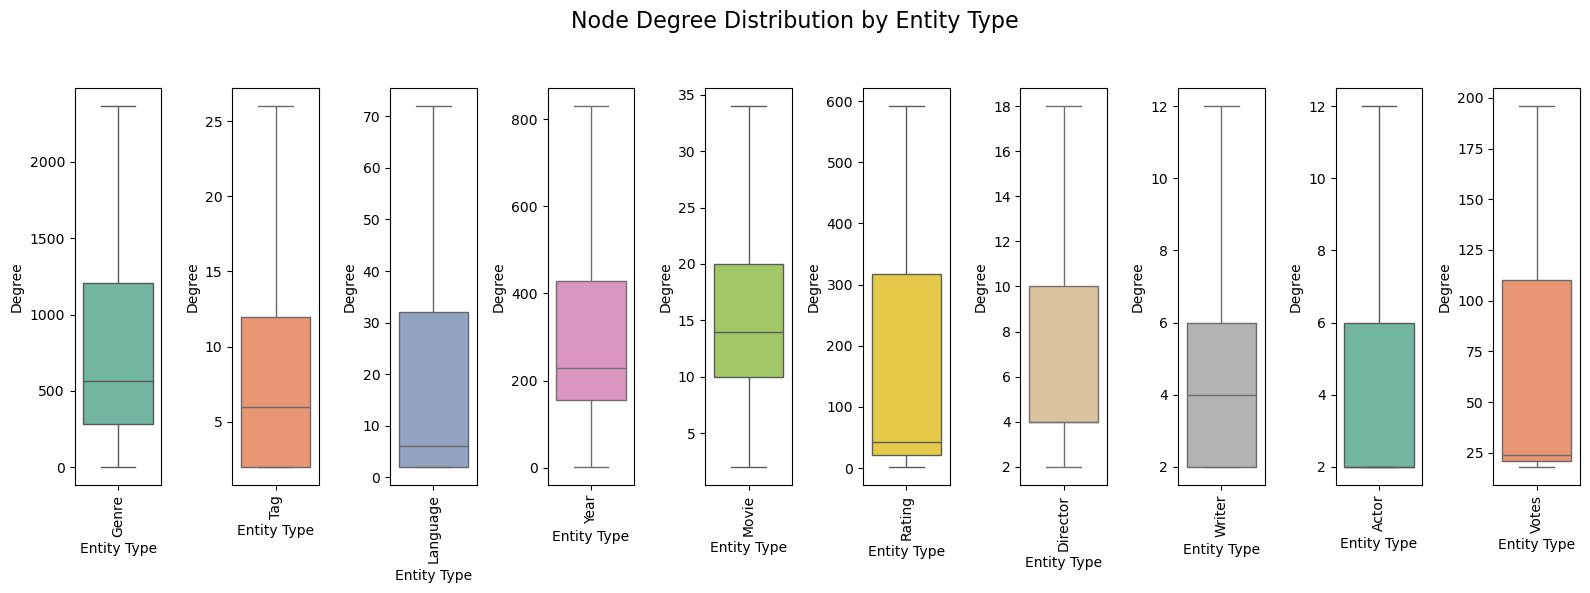

In [11]:
data = []
for entity_types, degree in degree_by_entity_type:
    for entity_type in entity_types:
        data.append((entity_type, degree))

data = pd.DataFrame(data, columns=['Entity Type', 'Degree'])

entity_types = data['Entity Type'].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(entity_types), figsize=(16, 6))

palette = sns.color_palette('Set2', len(entity_types))

for idx, entity_type in enumerate(entity_types):
    entity_data = data[data['Entity Type'] == entity_type]
    sns.boxplot(x='Entity Type', y='Degree', data=entity_data, ax=axes[idx], color=palette[idx], showfliers=False)
    axes[idx].tick_params(axis='x', rotation=90)

fig.suptitle('Node Degree Distribution by Entity Type', fontsize=16)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

Visualize graph schema

In [12]:
schema_df = kb_df[['subject_type', 'object_type', 'relation']].drop_duplicates(ignore_index=True)
schema_G = nx.from_pandas_edgelist(schema_df, source='subject_type', target='object_type', edge_attr='relation', create_using=nx.DiGraph())

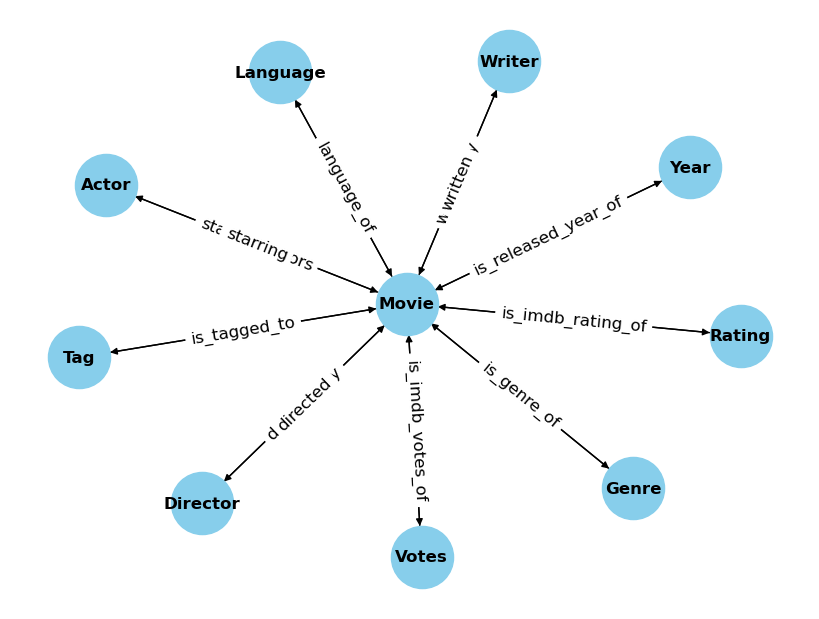

In [13]:
# Assuming schema_G is your graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(schema_G)  # Layout of the graph

# Draw nodes and labels
nx.draw(schema_G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=12, font_weight='bold')
edge_labels = nx.get_edge_attributes(schema_G, 'relation')
nx.draw_networkx_edge_labels(schema_G, pos, edge_labels = edge_labels, font_size = 12)

plt.show()

Find suitable questions for visualization
-   size between 100 to 200 nodes

In [43]:
def get_nodes_within_2_hops(G, entity):
    if entity in G:
        return list(nx.single_source_shortest_path_length(G, entity, cutoff=2).keys())

subgraph_nodes = []
subgraph_size = []

end_idx = 2000
for q_ent in query_entities[:end_idx]:
    nodes = get_nodes_within_2_hops(G, q_ent)
    subgraph_nodes.append(nodes)
    subgraph_size.append(len(nodes))

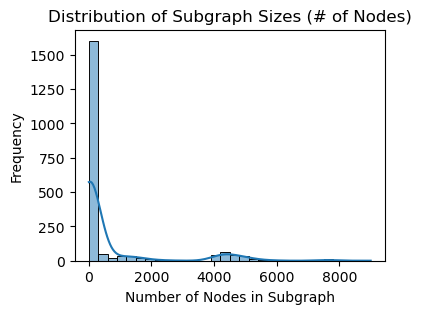

In [15]:
plt.figure(figsize=(4, 3))

# Plotting a histogram to show the distribution of subgraph sizes (number of nodes)
sns.histplot(subgraph_size, bins=30, kde=True)  # kde=True adds a kernel density estimate curve
plt.title("Distribution of Subgraph Sizes (# of Nodes)")
plt.xlabel("Number of Nodes in Subgraph")
plt.ylabel("Frequency")
plt.show()

Visualize boxplot, ignoring outliers

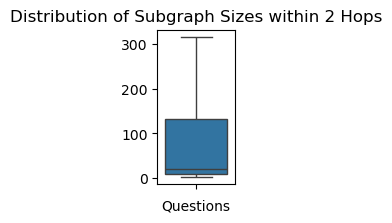

In [16]:
plt.figure(figsize=(1, 2))
sns.boxplot(data=subgraph_size, showfliers=False)

plt.title("Distribution of Subgraph Sizes within 2 Hops")
plt.xlabel("Questions")
plt.show()

In [17]:
# get the indices where subgraph size is <= 200
indices_in_range = [i for i, size in enumerate(subgraph_size) if size <= 200]

ratios = []

for i in indices_in_range:
    pos_to_neg_ratio = len(answers[i])/subgraph_size[i]
    ratios.append(pos_to_neg_ratio)
    print(pos_to_neg_ratio, len(answers[i]), subgraph_size[i])

0.14285714285714285 1 7
0.14285714285714285 1 7
0.05405405405405406 2 37
0.047619047619047616 1 21
0.022222222222222223 1 45
0.15384615384615385 2 13
0.017241379310344827 1 58
0.2 3 15
0.3 3 10
0.078125 5 64
0.25 4 16
0.16666666666666666 1 6
0.08333333333333333 1 12
0.0625 1 16
0.058823529411764705 1 17
0.4444444444444444 4 9
0.05555555555555555 1 18
0.14285714285714285 3 21
0.043478260869565216 1 23
0.10526315789473684 2 19
0.25 2 8
0.09302325581395349 4 43
0.15384615384615385 2 13
0.005988023952095809 1 167
0.07142857142857142 1 14
0.0967741935483871 3 31
0.15789473684210525 3 19
0.0967741935483871 3 31
0.3333333333333333 3 9
0.125 1 8
0.18181818181818182 2 11
0.08333333333333333 2 24
0.09375 3 32
0.14285714285714285 1 7
0.36363636363636365 4 11
0.038461538461538464 1 26
0.13636363636363635 3 22
0.1076923076923077 7 65
0.125 1 8
0.13793103448275862 4 29
0.10416666666666667 5 48
0.058823529411764705 1 17
0.08695652173913043 2 23
0.0967741935483871 3 31
0.022727272727272728 1 44
0.1 1 

Positve to negative ratio distribution

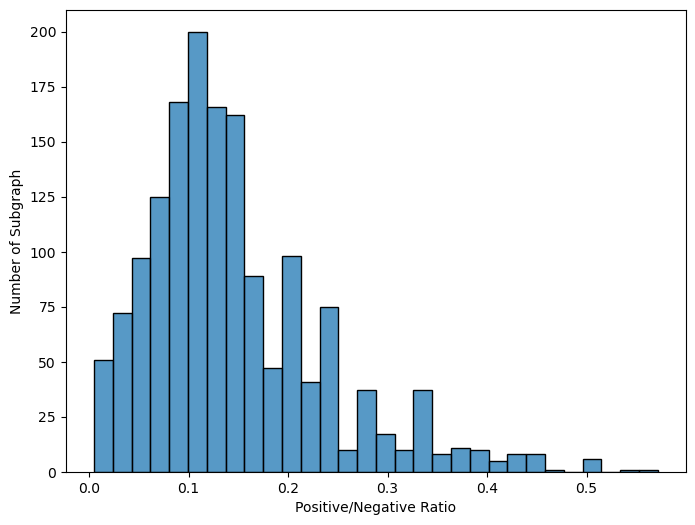

In [18]:
plt.figure(figsize=(8, 6))

sns.histplot(ratios, bins=30)  # kde=True adds a kernel density estimate curve
# plt.title("Distribution of Positive/Negative Ratio")
plt.xlabel("Positive/Negative Ratio")
plt.ylabel("Number of Subgraph")
plt.show()

In [19]:
# get the indices where subgraph size is between 100 and 200
indices_in_range = [i for i, size in enumerate(subgraph_size) if 100 <= size <= 200]

for i in indices_in_range:
    print(i, subgraph_size[i])

33 167
64 197
79 105
86 106
103 108
123 169
165 122
174 198
177 138
182 171
219 138
227 129
238 175
244 118
258 122
285 171
309 158
339 196
348 153
367 183
382 103
386 107
410 146
426 180
440 193
455 108
461 176
472 100
478 116
491 113
510 181
519 102
536 189
551 113
552 116
575 178
593 185
601 119
607 129
627 141
630 156
641 134
649 140
650 195
651 177
665 139
682 183
686 105
704 158
746 134
763 110
768 106
773 133
794 126
810 155
815 139
851 193
863 106
878 119
916 139
960 132
974 176
990 118
1043 190
1074 110
1121 125
1123 185
1133 102
1153 142
1161 193
1174 167
1237 150
1250 177
1256 170
1259 122
1271 129
1301 140
1313 155
1327 107
1381 115
1480 164
1485 200
1491 169
1493 100
1502 103
1504 105
1520 167
1538 101
1576 106
1580 196
1584 163
1593 191
1594 115
1601 164
1646 105
1672 123
1718 111
1720 117
1767 141
1821 137
1886 140
1912 160
1920 131
1925 101
1934 108
1937 114
1964 179
1968 124
1977 133
1993 140


Choose q_idx=86

In [44]:
q_idx = 86
# Get question entity, ground truth answer, ans candidates
q_ent = query_entities[q_idx]
ans_gt = answers[q_idx]
ans_candidates = subgraph_nodes[q_idx]
question = questions[q_idx]
print(question)
q_ent, ans_gt, ans_candidates

when did the movies directed by Bryan Singer release


('Bryan Singer',
 ['1993', '1995', '1998', '2000', '2006', '2008', '2013'],
 ['Bryan Singer',
  'Public Access',
  'Apt Pupil',
  'Jack the Giant Slayer',
  'The Usual Suspects',
  'Valkyrie',
  'Superman Returns',
  'X-Men',
  'Christopher McQuarrie',
  'Michael Feit Dougan',
  '1993',
  'Drama',
  'Stephen King',
  'Ian McKellen',
  'Brad Renfro',
  '1998',
  'Thriller',
  'violence',
  'nazis',
  'stephen king',
  'holocaust',
  'own',
  'ian mckellen',
  'bryan singer',
  'nazi',
  'Darren Lemke',
  'Dan Studney',
  'Ewan McGregor',
  'Stanley Tucci',
  'Nicholas Hoult',
  'Eleanor Tomlinson',
  '2013',
  'English',
  'Adventure',
  'Fantasy',
  'fantasy',
  'fairy tale',
  'ewan mcgregor',
  'giants',
  'Benicio Del Toro',
  'Gabriel Byrne',
  'Kevin Pollak',
  'Stephen Baldwin',
  '1995',
  'Crime',
  'classic',
  'thriller',
  'crime',
  'r',
  'kevin spacey',
  'los angeles',
  'benicio del toro',
  'complex',
  'gabriel byrne',
  'pete postlethwaite',
  'kevin pollak',
  'Tom 

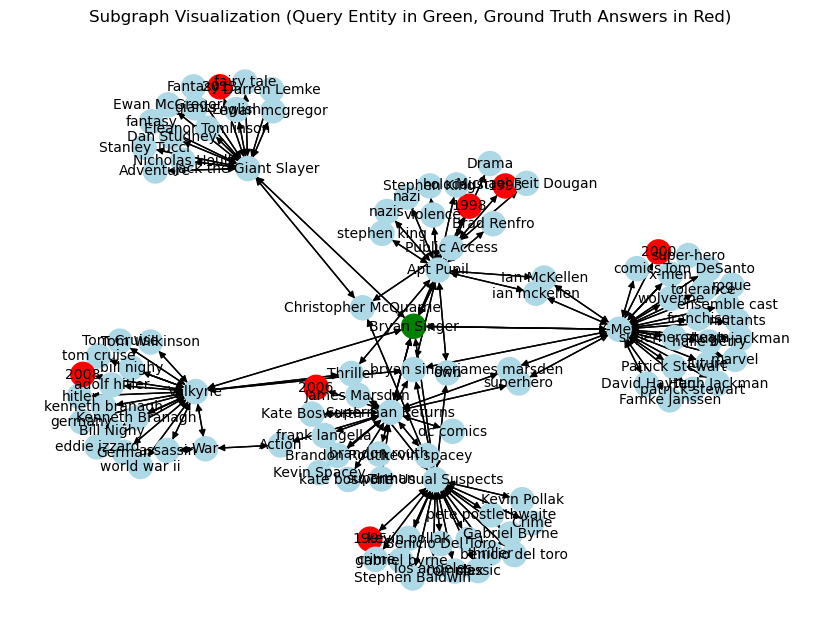

In [45]:
subgraph = G.subgraph(ans_candidates)

subgraph_node_colors = [
    'red' if node in ans_gt else 
    'green' if node == q_ent else 
    'lightblue' for node in subgraph.nodes
]

# Visualize the subgraph
plt.figure(figsize=(8, 6))
nx.draw(subgraph, with_labels=True, node_color=subgraph_node_colors, font_size=10)
plt.title("Subgraph Visualization (Query Entity in Green, Ground Truth Answers in Red)")
plt.show()

Get node embeddings

In [46]:
collaspe_G, _ = generate_nx_graph(path_to_kb, collaspe_relations=True)

def get_node2vec(sub_nodes):
    # node2vec
    path_to_node_embed = '../Datasets/MetaQA_dataset/processed/node2vec _embeddings/ud_node2vec_embeddings.txt'
    node_embeddings = load_node2vec_embeddings(path_to_node_embed, embedding_dim=64)
    subgraph_embeddings = np.array([node_embeddings[node] for node in sub_nodes])
    return subgraph_embeddings

def get_sbert_question_and_paths(sub_nodes, collaspe_G, q_ent, question):
    q_embedding = model.encode(question, batch_size=128, convert_to_tensor=True) # 32
    node_embeddings = find_best_embedding(collaspe_G, q_ent, q_embedding)
    node_embeddings[q_ent] = q_embedding
    subgraph_embeddings = np.array([np.array(node_embeddings[node], dtype=np.float32) for node in sub_nodes])
    return subgraph_embeddings
    
def get_sbert_nodes(sub_nodes):
    subgraph_embeddings = model.encode(sub_nodes, batch_size=128, convert_to_tensor=True) # 32
    return subgraph_embeddings

In [47]:
from sklearn.manifold import TSNE

def visualize_node_embeddings(subgraph_embeddings, subgraph, name):
    # Perform t-SNE to reduce embeddings to 2D
    tsne = TSNE(n_components=2, random_state=32)
    embeddings_2d = tsne.fit_transform(subgraph_embeddings)

    subgraph_node_colors = [
        'red' if node in ans_gt else 
        'green' if node == q_ent else 
        'lightblue' for node in subgraph.nodes
    ]

    # Plot the 2D embeddings with corresponding colors
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=subgraph_node_colors, s=100)

    # Annotate nodes with labels
    for i, node in enumerate(subgraph.nodes):
        plt.annotate(node, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=10, ha='center')

    plt.title(f"TSNE Visualization of Node Embeddings ({name})")
    plt.show()

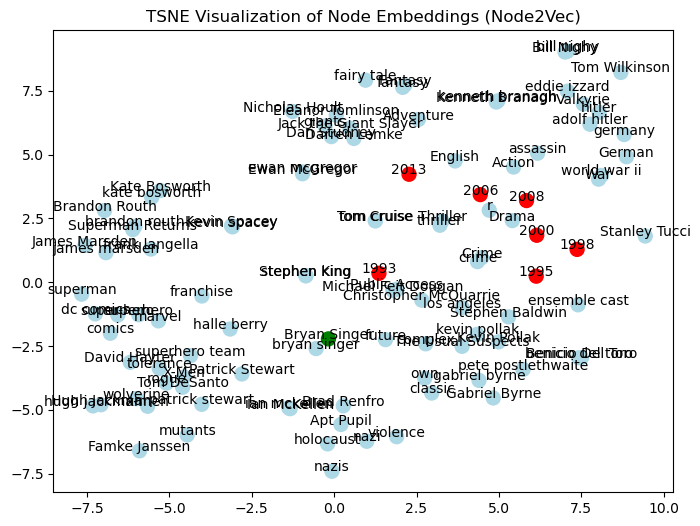

In [48]:
sub_nodes = [node for node in subgraph.nodes]
subgraph_embeddings = get_node2vec(sub_nodes)
visualize_node_embeddings(subgraph_embeddings, subgraph, "Node2Vec")

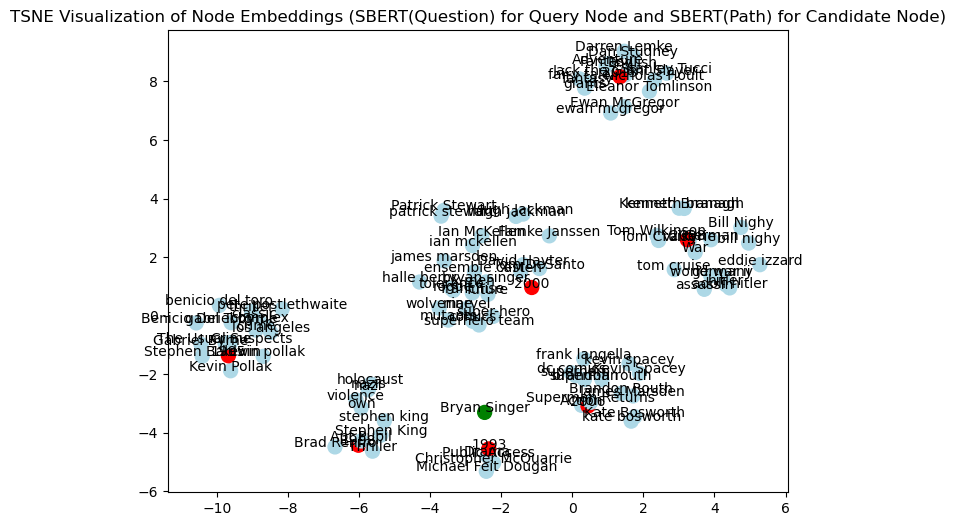

In [49]:
subgraph_embeddings = get_sbert_question_and_paths(sub_nodes, collaspe_G, q_ent, question)
visualize_node_embeddings(subgraph_embeddings, subgraph, "SBERT(Question) for Query Node and SBERT(Path) for Candidate Node")

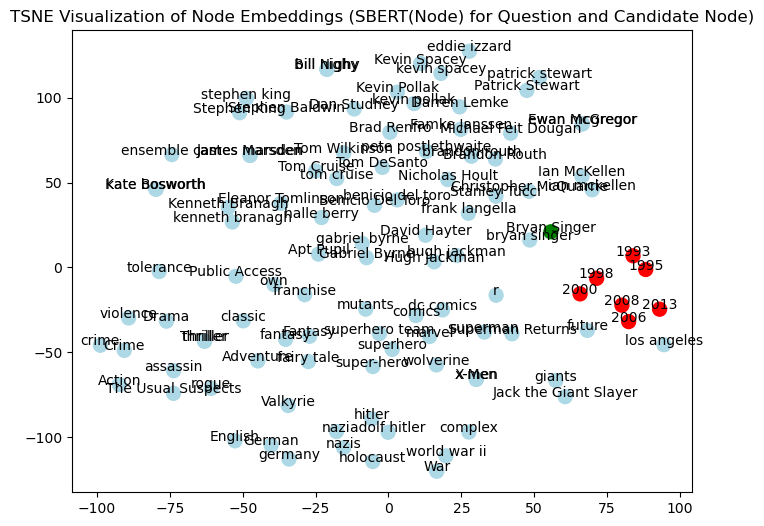

In [50]:
subgraph_embeddings = get_sbert_nodes(sub_nodes)
visualize_node_embeddings(subgraph_embeddings, subgraph, "SBERT(Node) for Question and Candidate Node")